In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_pipeline import transformation_pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.random.set_seed(2111)

In [2]:

data = pd.read_csv('content/preprocessed_train.csv')

# let's pick the data wiht primary_use==0
data = data.query('primary_use==0 & meter==0')

In [3]:
b_id = [118, 646, 125]

In [4]:
def plot_output(actual, predicted, title, building_idx, avg_loss, avg_rmse):
    fig, (ax1, ax2, ax) = plt.subplots(3, 1,  figsize=(30, 15), sharex=True)

    fig.suptitle(
        f'{title} model for building {building_idx}\nmse={avg_loss:.5f}\nrmse={avg_rmse:.5f}', fontsize=24)

    ax1.plot(range(len(actual)),
             predicted,
             color='green', linestyle='dashed')
    ax1.set_title('Predicted')
    ax1.set_ylim(0, 1)

    ax2.plot(range(len(actual)),
             actual,
             color='red', label='Actual')
    ax2.set_title('Actual')
    ax2.set_ylim(0, 1)

    ax.plot(range(len(actual)),
            predicted,
            color='green', linestyle='dashed',
            label='Predicted')

    ax.plot(range(len(actual)),
            actual,
            color='red',
            label='actual')
    ax.set_ylim(0, 1)
    plt.legend()
    plt.show()
    fig.savefig(
        f'Final Plots for the research/tune on 20/{title} model -- building {building_idx} -- mse {avg_loss:.5f} -- rmse {avg_rmse:.5f}.png')

# %%

# function to laod certain building id


def loading_data(idx, train_size):
    pipeline, data_cleaned = transformation_pipeline(
        data, building_id=idx, meter=0, primary_use=0)

    train, test = train_test_split(data_cleaned,
                                   # [:, 1:],
                                   #transformed_data[:, 0],
                                   train_size=train_size,
                                   shuffle=False,
                                   random_state=2021)

    train_data = pipeline.fit_transform(train)
    test_data = pipeline.transform(test)

    x_train, y_train = train_data[:, 1:], train_data[:, 0]

    x_val, y_val = test_data[:, 1:], test_data[:, 0]

    train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train,
                                                                    y_train,
                                                            length=6, sampling_rate=1,
                                                             stride=1,
                                                             batch_size=32,
                                                                shuffle=False)

    val_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_val,
                                                                  y_val,
                                                      length=6, sampling_rate=1,
                                                      stride=1, batch_size=350,
                                                      shuffle=False
                                                      )
    return train_gen, val_gen[2]

In [6]:
pd.options.mode.chained_assignment = None
# %% loading models to evaluate them on new data
import time


transformer_model = tf.keras.models.load_model('models/Transformer_adam')
lstm_model = tf.keras.models.load_model('models/LSTM_ADAM')
rnn_model = tf.keras.models.load_model('models/RNN_ADAM')

models =[transformer_model, lstm_model, rnn_model ]

i2txt={0:'transformer', 1:'lstm', 2:'rnn'}

finetuning_data = {}
for building_idx in b_id:
    train_gen, test_gen = loading_data(building_idx, 0.2)
    finetuning_data[building_idx] = {}
    for i , model in enumerate(models):
        predicted = np.array([])
        actual = np.array([])

        txt = i2txt[i]

        finetuning_data[building_idx][txt] = []

        #model = tf.keras.models.load_model(model_address)

       # start_time = time.time()

        model.fit(train_gen, epochs=15, verbose=False)


        

       # time_taken = time.time() - start_time
       # print(f"model {txt} took {time.time() - start_time} seconds")

        predicted = np.append(predicted, model.predict(test_gen[0]))
        actual = np.append(actual, test_gen[1])

        # avg_mse = np.mean((actual - predicted)**2)
        # avg_rmse = np.sqrt(np.mean((actual - predicted)**2))

        # #finetuning_data[building_idx][txt].append(
        # #    (avg_mse, avg_rmse, time_taken))

        # mape= np.mean(np.abs(np.divide((predicted - actual),(actual + 1e-15))))

        # print(f'{txt} Model \nbuilding: {building_idx} \nmse= {avg_mse} \nrmse] {avg_rmse} \nmape= {mape}\n----------')

        #plot_output(actual, predicted, txt, building_idx, avg_mse, avg_rmse)

transformer Model 
building: 118 
mse= 0.012674697003649427 
rmse] 0.11258195682989983 
mape= 0.2359002207445606
----------
lstm Model 
building: 118 
mse= 0.015496553715420244 
rmse] 0.12448515459853132 
mape= 0.25812130219723334
----------
rnn Model 
building: 118 
mse= 0.03151590452557652 
rmse] 0.17752719376359363 
mape= 0.3590789103727026
----------
transformer Model 
building: 646 
mse= 0.012950137541131527 
rmse] 0.11379867108684322 
mape= 0.8579077765967938
----------
lstm Model 
building: 646 
mse= 0.009762502620143814 
rmse] 0.09880537748596387 
mape= 0.7964183104578292
----------
rnn Model 
building: 646 
mse= 0.04461969273883195 
rmse] 0.21123373958445169 
mape= 1.301437115085142
----------
transformer Model 
building: 125 
mse= 0.0064847821423706115 
rmse] 0.08052814503247055 
mape= 0.12560951419247407
----------
lstm Model 
building: 125 
mse= 0.0053820263671844415 
rmse] 0.07336229526933057 
mape= 0.10877431671761831
----------
rnn Model 
building: 125 
mse= 0.0338892050

In [ ]:
# transformer, gru, lstm,rnn = [], [], [],[]
# for building_idx in b_id:

#     x, y, z,r = finetuning_data[building_idx].values()
#     transformer.append(x)
#     gru.append(y)
#     lstm.append(z)
#     rnn.append(r)
# # %%
# mse, rmse, t = [], [], []
# for d in [transformer, gru, lstm,rnn]:
#     for i in range(3):

#         mse.append(d[i][0][0])
#         rmse.append(d[i][0][1])
#         t.append(d[i][0][2])

#     d.append([np.mean(mse), np.mean(rmse), np.mean(t)])

# # %%
# for d, n in zip([transformer, gru, lstm,rnn], ['transformer', 'gru',
#                                                'lstm','rnn']):
#     print(f'--- {n} ---')
#     print(' mse \t rmse \t time')
#     print(f'{d[3][0]:0.4f}\t{d[3][1]:0.4f}\t{d[3][2]:0.4f}')

In [76]:
def loading_data_adjusted(idx, train_size):
    pipeline, data_cleaned = transformation_pipeline(
        data, building_id=idx, meter=0, primary_use=0)

    train, test = train_test_split(data_cleaned,
                                   # [:, 1:],
                                   #transformed_data[:, 0],
                                   train_size=train_size,
                                   shuffle=False,
                                   random_state=2021)

    train_data = pipeline.fit_transform(train)
    test_data = pipeline.transform(test)

    x_train, y_train = train_data[:, 1:], train_data[:, 0]

    x_val, y_val = test_data[:, 1:], test_data[:, 0]

    train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train,
                                                                    y_train,
                                                            length=6, sampling_rate=1,
                                                             stride=1,
                                                             batch_size=32,
                                                                shuffle=False)

    val_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_val,
                                                                  y_val,
                                                      length=6, sampling_rate=1,
                                                      stride=1, batch_size=350,
                                                      shuffle=False
                                                      )
    return train_gen, val_gen[0]



transformer_predicted= np.array([])
lstm_predicted= np.array([])
rnn_predicted= np.array([])
actual=  np.array([])
_, test_gen = loading_data_adjusted( 118 , 0.2)


transformer_predicted = np.append(transformer_predicted, transformer_model.predict(test_gen[0][100:268] ))
lstm_predicted = np.append(lstm_predicted, lstm_model.predict(test_gen[0][100:268] ))
rnn_predicted = np.append(rnn_predicted, rnn_model.predict(test_gen[0][100:268] ))

actual = np.append(actual, test_gen[1][100:268] )

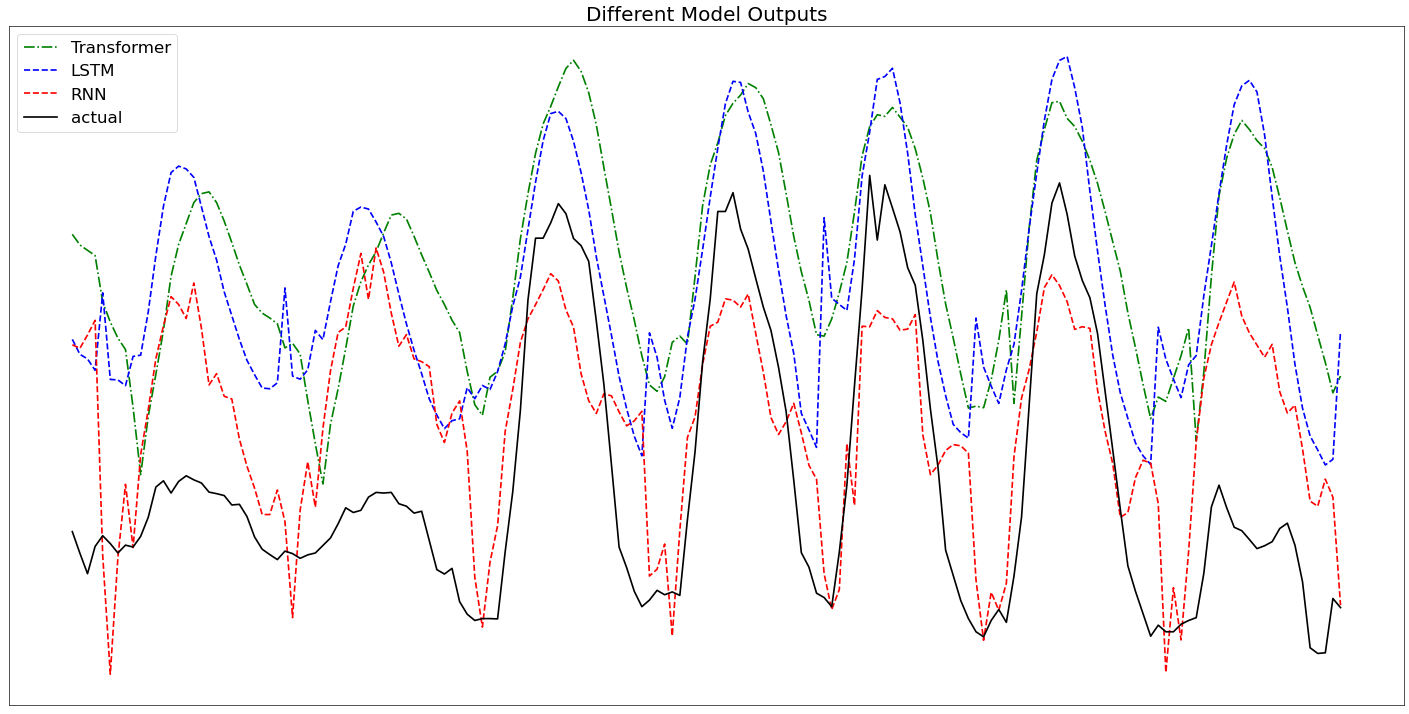

In [77]:

fig, ax = plt.subplots(1, 1,  figsize=(30, 15), dpi=60)

ax.set_title( 'Different Model Outputs', fontsize=24)

ax.plot(
        transformer_predicted,
        color='green', linestyle='-.', linewidth=2,
        label='Transformer')

ax.plot(
        lstm_predicted,
        color='blue', linestyle='--', linewidth=2 ,
        label='LSTM')

ax.plot(
        rnn_predicted,
        color='red',  linestyle='--', linewidth=2 ,
        label='RNN')

ax.plot(
        actual,
        color='black',  linestyle='-', linewidth=2,
        label='actual')

ax.set_yticks([])
ax.set_xticks([])

#ax.set_ylim(0, 1)
plt.legend(fontsize=20)
plt.show()

# fig.savefig(
#      f'Final Plots for the research/tune on 20/{title} model -- building {building_idx} -- mse {avg_loss:.5f} -- rmse {avg_rmse:.5f}.png')
